In [4]:
pip install tree

Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123
print("ok")

ok


In [ ]:
!apt-get install tree
#clear_output()
# Creamos las carpetas que contendrán las imagenes de entrenamiento
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

In [ ]:
IMG_PATH = 'C:\\Modelos\\Brain_tumor\\Brain_Tumor_Detection'
# Divide las imagenes del dataset original en train/val/test
for CLASS in os.listdir(IMG_PATH):
   #if os.path.isdir(CLASS):
    if (os.path.isfile(CLASS)==False) and (CLASS=="yes" or CLASS=="no"):
        print(CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            print(img)
            if n < 25:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                print("TO TEST")
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                print("TO TRAIN")
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)
                print("TO VAL")


In [6]:
def load_data(dir_path, img_size=(100,100)):
    #Carga las imagebes como np.arrays y les cambia el tamaño
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X,dtype=object)
    y = np.array(y)
    print(f'{len(X)} imagenes cargadas desde: {dir_path}.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta funcion imprime y plotea la matriz de confucion.
    Se puede aplicar Normalization haciendo `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# Cargamos cada uno de los conjuntos de imagener entrenamiento
# prueba y validación
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
print(labels)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


253 imagenes cargadas desde: TRAIN/.
{0: 'NO', 1: 'YES'}


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


253 imagenes cargadas desde: TEST/.


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

253 imagenes cargadas desde: VAL/.


In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Crea un gridplot para mostrar un número deseado de imágenes  
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

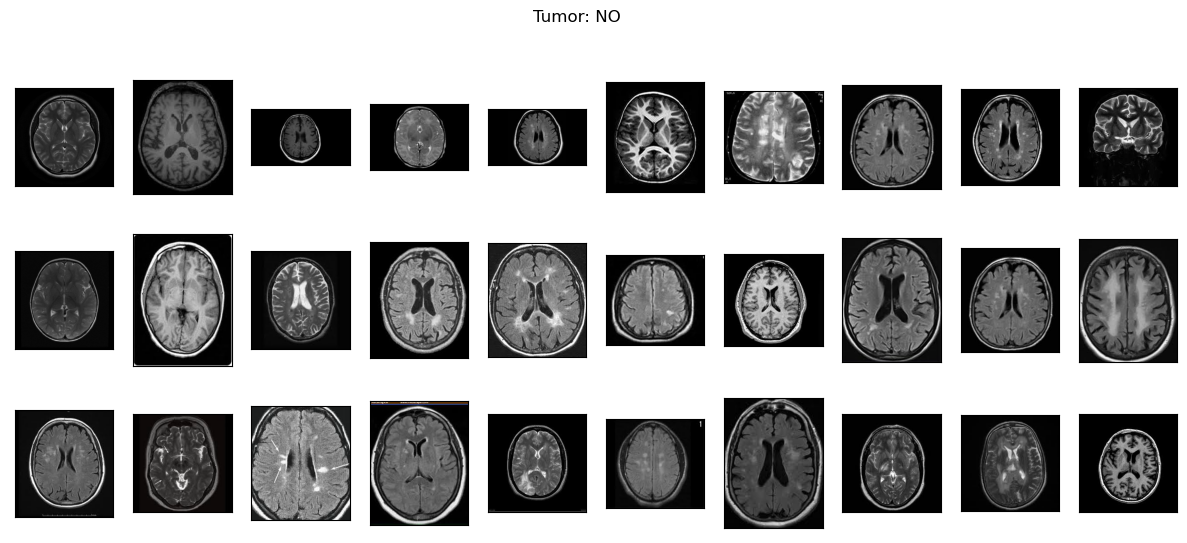

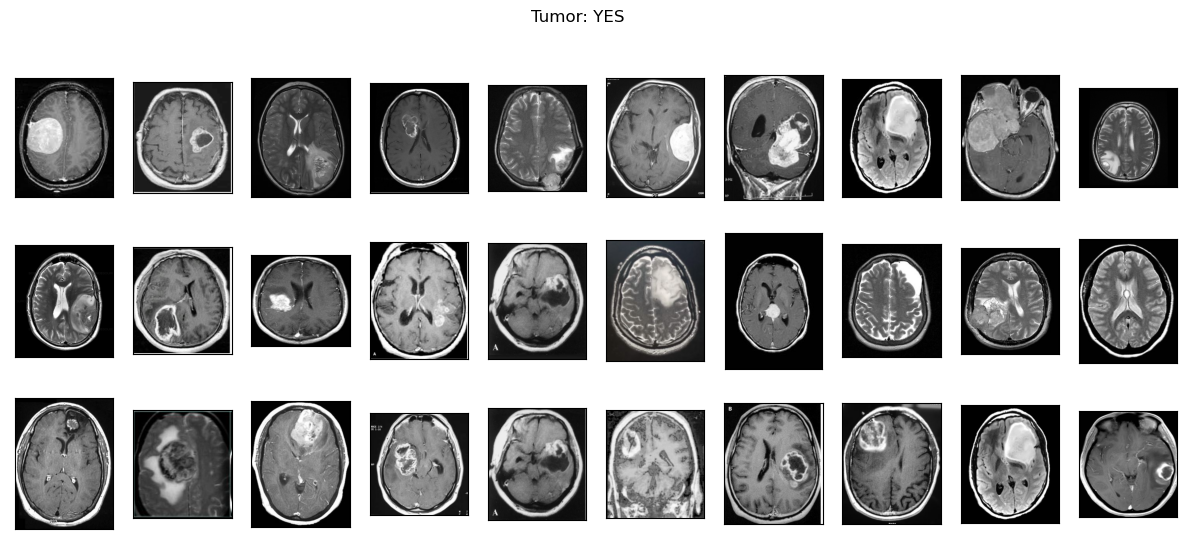

In [9]:
plot_samples(X_train, y_train, labels, 30)

In [10]:
# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
     
       .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

<>:62: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:76: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:62: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:76: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

C:\Users\david\AppData\Local\Temp\ipykernel_9704\2056755688.py:62: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

C:\Users\david\AppData\Local\Temp\ipykernel_9704\2056755688.py:76: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Encuentra los puntos extremos de la imagen y la corta de forma rectangular
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        homo_filter = HomomorphicFilter(a = 0.9, b = 1.4)
        new_img = homo_filter.filter(I=new_img, filter_params=[30,2])
        new_img = cv2.equalizeHist(new_img)
        new_img = cv2.cvtColor(new_img,cv2.COLOR_GRAY2RGB)
        set_new.append(new_img)

    return np.array(set_new, dtype=object)

In [12]:
# Aplicamos a cada uno de los subconjuntos
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

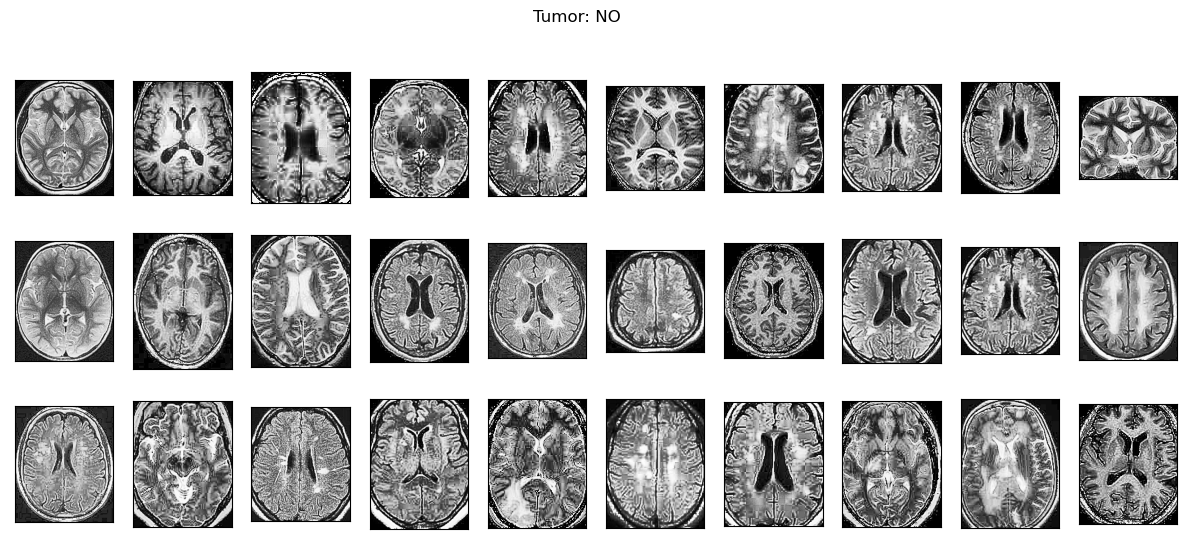

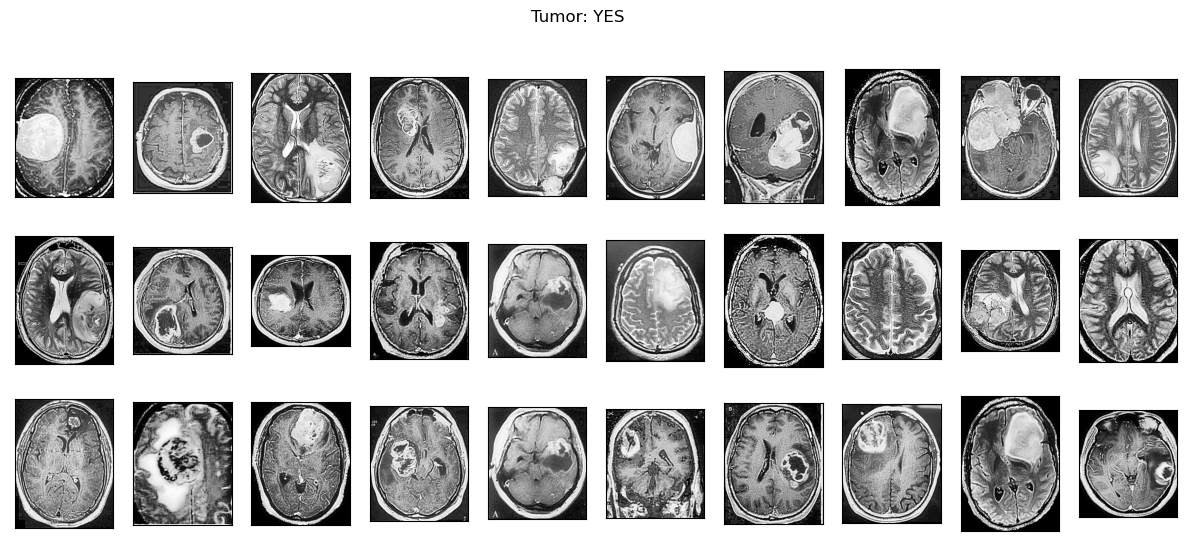

In [13]:
plot_samples(X_train_crop, y_train, labels, 30)

In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# Creamos las carpetas donde guardaremos las imagenes
#!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES 
#!mkdir TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES 
#!mkdir VAL_CROP/NO
# Guardamos las imagenes que recortamos en las carpetas anteriores
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [15]:
def preprocess_imgs(set_name, img_size):
    """
    Resiza y aplica preprocesamiento VGG-15
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [16]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

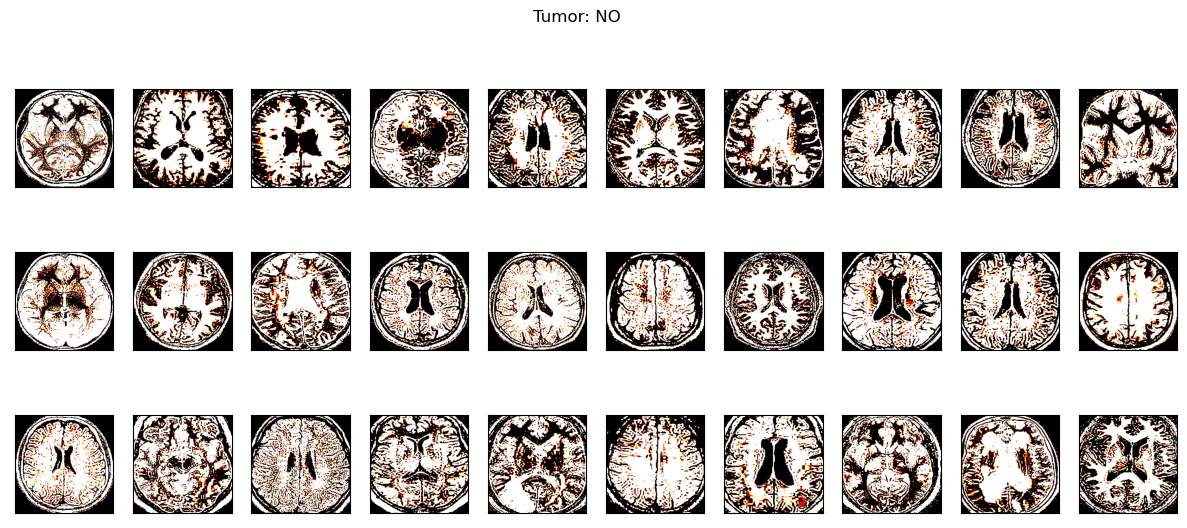

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

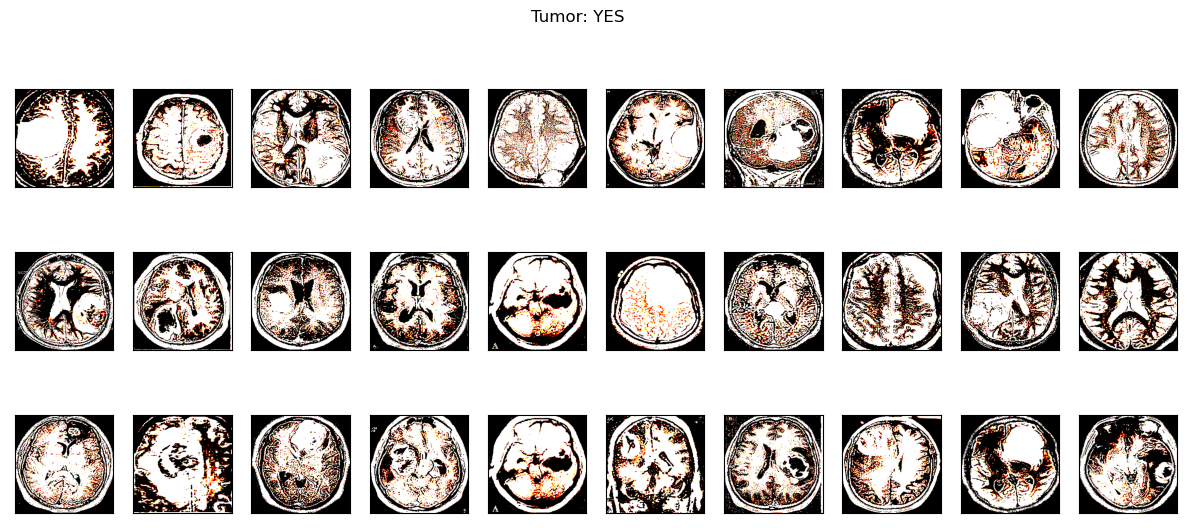

In [17]:
plot_samples(X_train_prep, y_train, labels, 30)

In [18]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [83]:
# Cargamos el modelo Base
base_model = VGG16(
     #weights="../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
     include_top=False, 
     input_shape=IMG_SIZE + (3,)
)

NUM_CLASSES = 1
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_31 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_31 (Dropout)        (None, 25088)             0         
                                                                 
 dense_123 (Dense)           (None, 1024)              25691136  
                                                                 
 dense_124 (Dense)           (None, 100)               102500    
                                                                 
 dense_125 (Dense)           (None, 64)                6464      
                                                                 
 dense_126 (Dense)           (None, 1)               

In [84]:
EPOCHS = 30
batch_size=32
val_batch_size=16
es = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_test)//val_batch_size,
    callbacks=[es]
)

Epoch 1/30
7/7 [==============================] - 42s 6s/step - loss: 2.9696 - accuracy: 0.5747 - val_loss: 1.0997 - val_accuracy: 0.7750
Epoch 2/30
7/7 [==============================] - 44s 7s/step - loss: 1.8645 - accuracy: 0.6471 - val_loss: 1.0274 - val_accuracy: 0.7083
Epoch 3/30
7/7 [==============================] - 45s 7s/step - loss: 1.2709 - accuracy: 0.7376 - val_loss: 0.6777 - val_accuracy: 0.7625
Epoch 4/30
7/7 [==============================] - 48s 7s/step - loss: 1.3359 - accuracy: 0.6968 - val_loss: 0.8567 - val_accuracy: 0.7875
Epoch 5/30
7/7 [==============================] - 45s 7s/step - loss: 1.0917 - accuracy: 0.7768 - val_loss: 0.8736 - val_accuracy: 0.7750
Epoch 6/30
7/7 [==============================] - 43s 7s/step - loss: 0.8085 - accuracy: 0.7783 - val_loss: 0.7510 - val_accuracy: 0.7833
Epoch 7/30
7/7 [==============================] - 43s 7s/step - loss: 0.6554 - accuracy: 0.8054 - val_loss: 0.7069 - val_accuracy: 0.7750
Epoch 8/30
7/7 [==================

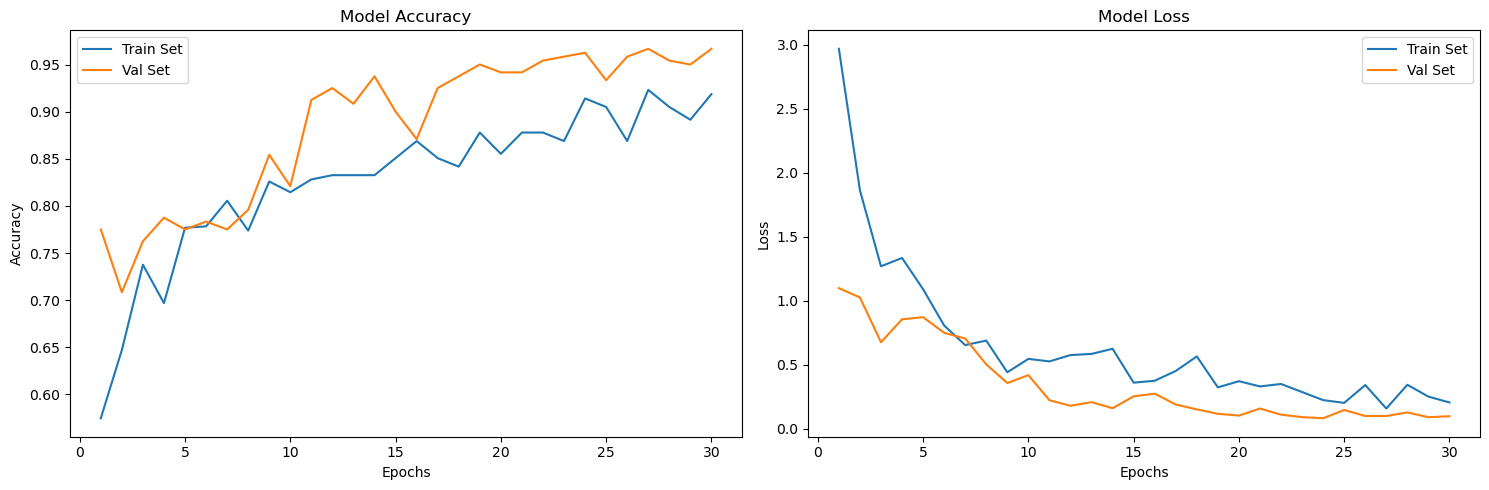

In [85]:
import pandas as pd
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

8/8 [==============================] - 21s 3s/step
Val Accuracy = 0.96


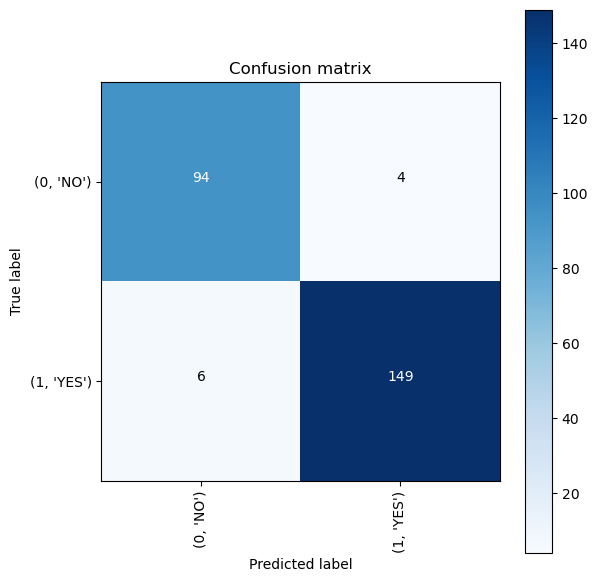

In [86]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


8/8 [==============================] - 22s 3s/step
Test Accuracy = 0.96


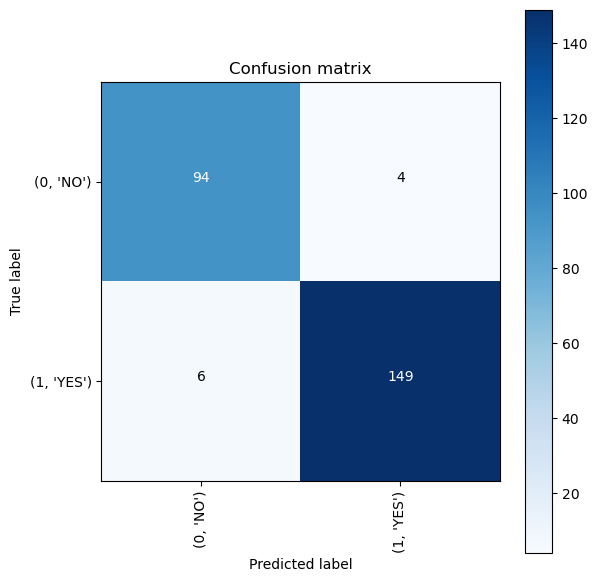

In [88]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)
confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [89]:
import tensorflow as tf
import zipfile
# clean up the space
#!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('2022-03-29_VGG16_model.h5')
#Para salvar el modelo en formato protobuf
Version="202203290002"
model_path=os.getcwd()
export_path=os.path.join(model_path,Version)
tf.saved_model.save(model,export_path)
modelZiped=zipfile.ZipFile("modelZiped.zip","w")
for folder, subfolders, files in os.walk(export_path):
     for file in files:
            modelZiped.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), ''), 
                             compress_type = zipfile.ZIP_DEFLATED)
modelZiped.close()


INFO:tensorflow:Assets written to: C:\Users\david\202203290002\assets


INFO:tensorflow:Assets written to: C:\Users\david\202203290002\assets
